# Stats on the ENPKG dataset

In [1]:
import os
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib_venn import venn2
from tqdm import tqdm

from rdkit import RDLogger
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles

from collections import defaultdict
import obonet
import networkx

pd.set_option("mode.chained_assignment", None)

In [2]:
RDLogger.DisableLog("rdApp.*")

In [3]:
DATA_DIR = "../data"
FIGURE_DIR = "../figures"

os.makedirs(FIGURE_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(f"{DATA_DIR}/raw", exist_ok=True)
os.makedirs(f"{DATA_DIR}/processed", exist_ok=True)

### Load dataset

In [4]:
df = pd.read_csv(
    f"{DATA_DIR}/raw/enpkg_completed_data.tsv.gz",
    sep="\t",
)
df.rename(
    columns={
        "?ik_2d": "inchikey",
        "?smiles": "smiles",
        "?np_class": "np_class",
        "?np_superclass": "np_superclass",
        "?np_pathway": "np_pathway",
        "?feature": "feature_id",
        "?cosmic": "confidence_score",
        "?species": "wikidata_species_id",
        "?adduct": "adduct",
    },
    inplace=True,
)
df["row_uid"] = np.arange(df.shape[0])
df["row_uid"] = df.row_uid.apply(lambda x: f"id_{x}")

df.head()

,inchikey,smiles,adduct,np_class,np_superclass,np_pathway,feature_id,confidence_score,wikidata_species_id,?massive_id,row_uid
0,<https://enpkg.commons-lab.org/kg/KAHZQJKLALFAGB>,CC(CCC(=O)O)C1CCC2C1(CCC3C2C(C(C4C3(CC(C(C4)O)...,[M+H]+,<https://enpkg.commons-lab.org/kg/npc_Cholane_...,<https://enpkg.commons-lab.org/kg/npc_Steroids>,<https://enpkg.commons-lab.org/kg/npc_Terpenoids>,<https://enpkg.commons-lab.org/kg/lcms_feature...,0.0969160648564248^^<http://www.w3.org/2001/XM...,<http://www.wikidata.org/entity/Q715019>,<https://massive.ucsd.edu/ProteoSAFe/dataset.j...,id_0
1,<https://enpkg.commons-lab.org/kg/LSUXCWJOIAWGOU>,CCCCCC=CCC=CCCCCCCCC(=O)OC(CO)COP(=O)(O)OCC[N+...,[M+H]+,<https://enpkg.commons-lab.org/kg/npc_unknown>,<https://enpkg.commons-lab.org/kg/npc_unknown>,<https://enpkg.commons-lab.org/kg/npc_unknown>,<https://enpkg.commons-lab.org/kg/lcms_feature...,0.2277398406031523^^<http://www.w3.org/2001/XM...,<http://www.wikidata.org/entity/Q715019>,<https://massive.ucsd.edu/ProteoSAFe/dataset.j...,id_1
2,<https://enpkg.commons-lab.org/kg/ZETHLDWUNRZGGA>,CC(C)CC(C(=O)C)NC(=O)C1CCCN1C(=O)C(C(C)C)NC(=O...,[M+Na]+,<https://enpkg.commons-lab.org/kg/npc_Tripepti...,<https://enpkg.commons-lab.org/kg/npc_Small_pe...,<https://enpkg.commons-lab.org/kg/npc_Amino_ac...,<https://enpkg.commons-lab.org/kg/lcms_feature...,0.2268625781121067^^<http://www.w3.org/2001/XM...,<http://www.wikidata.org/entity/Q715019>,<https://massive.ucsd.edu/ProteoSAFe/dataset.j...,id_2
3,<https://enpkg.commons-lab.org/kg/AWUQKIQOTXHCGE>,CCCCCCCC(C=CCCCCCCCC(=O)OCC(COP(=O)(O)OCC[N+](...,[M+H]+,<https://enpkg.commons-lab.org/kg/npc_unknown>,<https://enpkg.commons-lab.org/kg/npc_unknown>,<https://enpkg.commons-lab.org/kg/npc_unknown>,<https://enpkg.commons-lab.org/kg/lcms_feature...,0.1033609267294151^^<http://www.w3.org/2001/XM...,<http://www.wikidata.org/entity/Q715019>,<https://massive.ucsd.edu/ProteoSAFe/dataset.j...,id_3
4,<https://enpkg.commons-lab.org/kg/ASWBNKHCZGQVJV>,CCCCCCCCCCCCCCCC(=O)OC[C@@H](O)COP(=O)([O-])OC...,[M+H]+,<https://enpkg.commons-lab.org/kg/npc_unknown>,<https://enpkg.commons-lab.org/kg/npc_unknown>,<https://enpkg.commons-lab.org/kg/npc_unknown>,<https://enpkg.commons-lab.org/kg/lcms_feature...,0.2326475816840194^^<http://www.w3.org/2001/XM...,<http://www.wikidata.org/entity/Q715019>,<https://massive.ucsd.edu/ProteoSAFe/dataset.j...,id_4


In [5]:
df.shape

(1006797, 11)

### Data cleaning

In [6]:
df["inchikey"] = df["inchikey"].apply(lambda x: x.split("/")[-1].replace(">", ""))

df["np_class"] = df["np_class"].apply(
    lambda x: x.split("/")[-1].replace(">", "").split("npc_")[-1].replace("_", " ")
)
df["np_superclass"] = df["np_superclass"].apply(
    lambda x: x.split("/")[-1].replace(">", "").split("npc_")[-1].replace("_", " ")
)
df["np_pathway"] = df["np_pathway"].apply(
    lambda x: x.split("/")[-1].replace(">", "").split("npc_")[-1].replace("_", " ")
)

df["feature_id"] = df["feature_id"].apply(lambda x: x.split("/")[-1].replace(">", ""))

df["confidence_score"] = df["confidence_score"].apply(lambda x: x.split("^")[0])

df["wikidata_species_id"] = df["wikidata_species_id"].apply(
    lambda x: x.split("/")[-1].replace(">", "")
)

# Some NP Canopus predictions are doubled for some features so we remove them here
# Remove the columns that are not needed
df.drop(["np_class", "np_superclass", "np_pathway"], axis=1, inplace=True)
# Remove duplicates ignoring the row_uid
df.drop_duplicates(
    subset=df.columns.difference(["row_uid"]), keep="first", inplace=True
)

Filter for adduct [M+H]+ only

In [7]:
df = df[df["adduct"] == "[M+H]+"]

In [8]:
df.head(2)

,inchikey,smiles,adduct,feature_id,confidence_score,wikidata_species_id,?massive_id,row_uid
0,KAHZQJKLALFAGB,CC(CCC(=O)O)C1CCC2C1(CCC3C2C(C(C4C3(CC(C(C4)O)...,[M+H]+,lcms_feature_mzspec:MSV000093464:KP072_Positiv...,0.0969160648564248,Q715019,<https://massive.ucsd.edu/ProteoSAFe/dataset.j...,id_0
1,LSUXCWJOIAWGOU,CCCCCC=CCC=CCCCCCCCC(=O)OC(CO)COP(=O)(O)OCC[N+...,[M+H]+,lcms_feature_mzspec:MSV000093464:KP072_Positiv...,0.2277398406031523,Q715019,<https://massive.ucsd.edu/ProteoSAFe/dataset.j...,id_1


In [9]:
(
    df.inchikey.nunique(),
    df.wikidata_species_id.nunique(),
    df.smiles.nunique(),
    df.feature_id.nunique(),
    df.shape[0],
)

(41163, 1018, 41083, 335377, 335377)

### Distribution of features across the three plant datasets

In [10]:
def library_counter(lib_idx):
    tmp_df = df[df["library_massive_id"] == lib_idx]
    metabolite_counts = tmp_df["smiles"].nunique()
    features = tmp_df.shape[
        0
    ]  # duplicate entry due to multiple class/superclass/pathway annotations
    print(
        f"Library {lib_idx} has {metabolite_counts} unique metabolites and {features} features."
    )

In [11]:
df["library_massive_id"] = df["feature_id"].apply(lambda x: x.split(":")[1])

for i in df["library_massive_id"].unique():
    library_counter(i)

Library MSV000093464 has 10454 unique metabolites and 27163 features.
Library MSV000087728 has 33038 unique metabolites and 305852 features.
Library MSV000088521 has 1312 unique metabolites and 2362 features.


# Saved the cleaned dataframe

In [12]:
df["confidence_score"] = df["confidence_score"].astype(float)
df["type_by_confidence (t=0.5)"] = df["confidence_score"].apply(
    lambda x: "known" if x > 0.5 else "unknown"
)

In [13]:
(
    df[df["type_by_confidence (t=0.5)"] == "unknown"].inchikey.nunique(),
    df[df["type_by_confidence (t=0.5)"] == "known"].inchikey.nunique(),
)

(34808, 12434)

% of unknown [M+H]+ adduct features

In [14]:
round(df[df["type_by_confidence (t=0.5)"] == "unknown"].shape[0] / df.shape[0] * 100, 2)

74.93

In [15]:
df.to_csv(
    f"{DATA_DIR}/processed/enpkg_data_with_threshold.tsv.gz",
    sep="\t",
    index=False,
    compression="gzip",
)

### Load spectra table

In [16]:
spectra_df = pd.read_parquet(f"{DATA_DIR}/raw/all_enpkg_ms_features.pq")
spectra_df = spectra_df.rename(columns={"massive_idx": "library_massive_id"})
spectra_df.head(2)

,feature_id,scans,charge,retention_time,ms_level,precursor_mz,mz_list,i_list,library_massive_id,file_name,merged_stats,massive_id
0,1,1,1,823.362,2,282.2812,"[99.9018, 100.0766, 100.1135, 101.0787, 101.09...","[25.0, 1700.0, 440.0, 81.0, 100.0, 68.0, 20.0,...",MSV000093464,KP072_Positive_features_ms2_pos.mgf,None,lcms_feature_mzspec:MSV000093464:KP072_Positiv...
1,2,2,1,809.258,2,256.2658,"[100.0755, 101.155, 102.0719, 102.0944, 105.07...","[93.0, 34.0, 53.0, 450.0, 24.0, 48.0, 190.0, 1...",MSV000093464,KP072_Positive_features_ms2_pos.mgf,None,lcms_feature_mzspec:MSV000093464:KP072_Positiv...


In [17]:
spectra_df["feature_id"] = spectra_df.apply(
    lambda x: f"lcms_feature_mzspec:{x['library_massive_id']}:{x['file_name']}:scan:{x['scans']}",
    axis=1,
)

### Merging the spectra with metadata

In [18]:
combined_df = pd.merge(
    df,
    spectra_df,
    how="inner",
    on="feature_id",
)

Confirm they have the same number of features

In [19]:
(
    spectra_df["feature_id"].nunique(),
    combined_df["feature_id"].nunique(),
    df["feature_id"].nunique(),
    combined_df.shape[0],
)

(831778, 335377, 335377, 335377)

In [20]:
combined_df.to_parquet(f"{DATA_DIR}/raw/enpkg_m+h+only_with_ms_data.pq")

# Overview of the individual data stats within ENPKG

In [21]:
confidence_class_distribution = (
    combined_df[["inchikey", "type_by_confidence (t=0.5)"]]
    .drop_duplicates()
    .groupby("type_by_confidence (t=0.5)")
    .size()
    .to_dict()
)
confidence_class_distribution = {
    i.capitalize(): confidence_class_distribution[i]
    for i in confidence_class_distribution
}

# make a new column by splitting the "massive_id" column by ":" and getting the second element
combined_df["dataset"] = combined_df["massive_id"].str.split(":").str[1]

In [22]:
combined_df["adduct"].value_counts()

adduct
[M+H]+    335377
Name: count, dtype: int64

# Figure 1: Overview of the dataset

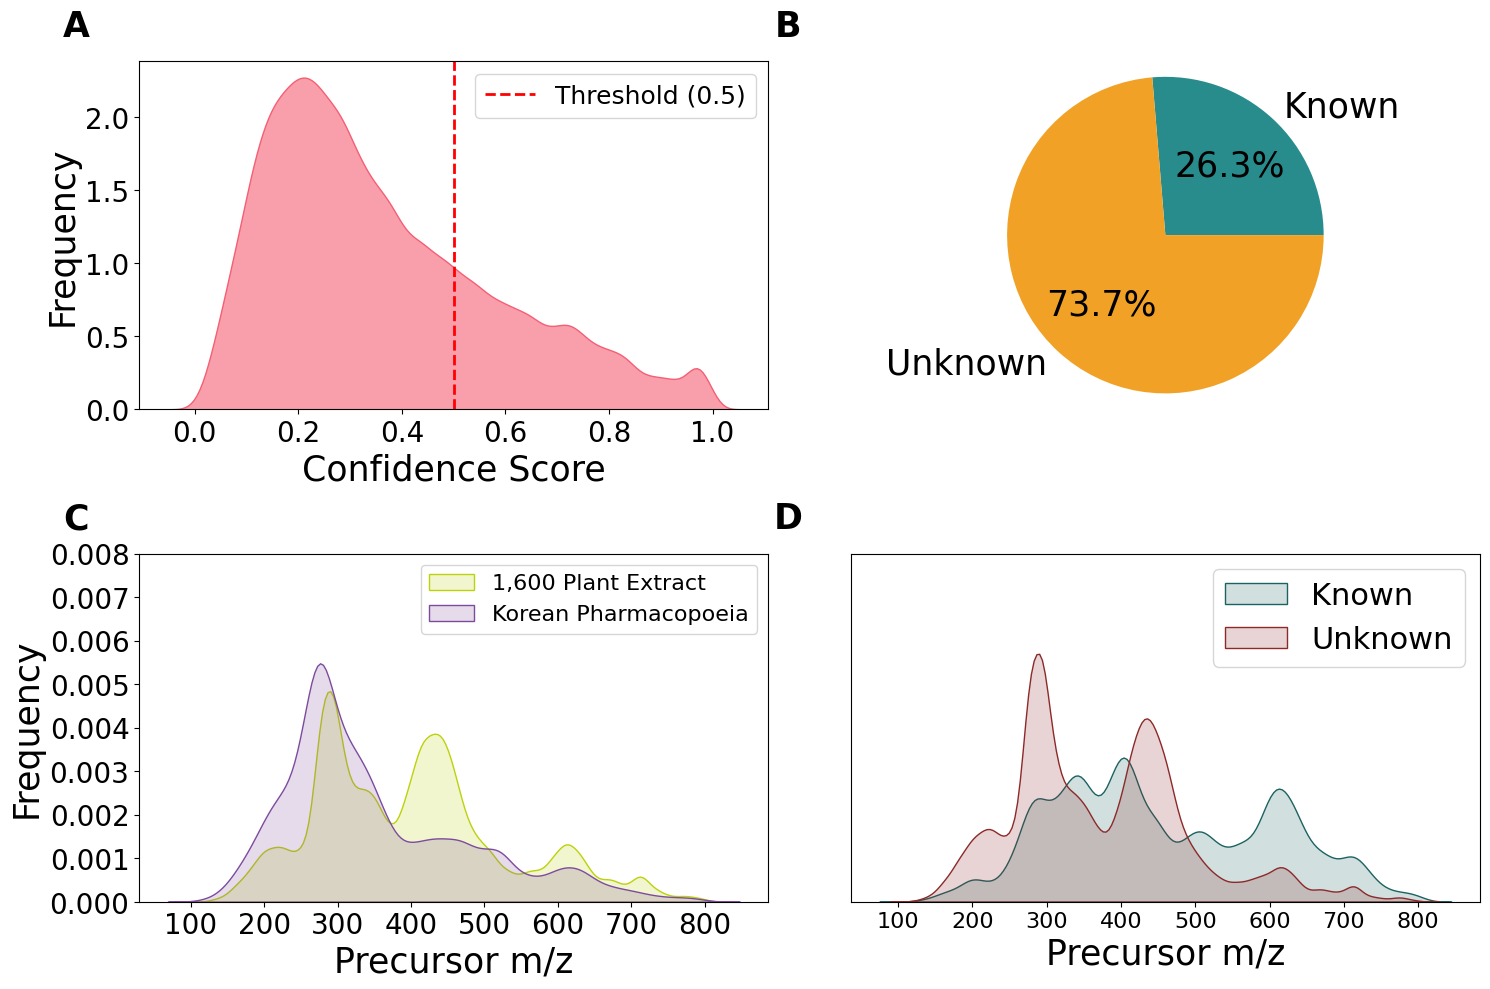

In [23]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.kdeplot(combined_df["confidence_score"], color="#F45F74", fill=True, alpha=0.6)
plt.axvline(
    x=0.5,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Threshold (0.5)",
)
plt.xlabel("Confidence Score", fontsize=25)
plt.ylabel("Frequency", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=18)
plt.text(
    -0.1,
    1.1,
    string.ascii_uppercase[0],
    size=25,
    weight="bold",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
)

plt.subplot(2, 2, 2)
plt.pie(
    confidence_class_distribution.values(),
    labels=confidence_class_distribution.keys(),
    autopct="%1.1f%%",
    colors=["#298C8C", "#F1A226"],
    textprops={"fontsize": 25},
)
plt.axis("equal")
plt.text(
    -0.1,
    1.1,
    string.ascii_uppercase[1],
    size=25,
    weight="bold",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
)

plt.subplot(2, 2, 3)

MSV000087728_plants = set(
    combined_df[combined_df["dataset"] == "MSV000087728"][
        "wikidata_species_id"
    ].unique()
)

MSV000093464_plants = set(
    combined_df[combined_df["dataset"] == "MSV000093464"][
        "wikidata_species_id"
    ].unique()
)

pierre_fabre_extracts = combined_df[combined_df["dataset"] == "MSV000087728"]
korean_med_plants = combined_df[combined_df["dataset"] == "MSV000093464"]
sns.kdeplot(
    pierre_fabre_extracts["precursor_mz"],
    color="#BCD20B",
    label="1,600 Plant Extract",
    fill=True,
    alpha=0.2,
)

sns.kdeplot(
    korean_med_plants["precursor_mz"],
    color="#7D4B9E",
    label="Korean Pharmacopoeia",
    fill=True,
    alpha=0.2,
)

plt.legend(fontsize=16)


plt.xlabel("Precursor m/z", fontsize=25)
plt.ylabel("Frequency", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0, 0.008)
plt.text(
    -0.1,
    1.1,
    string.ascii_uppercase[2],
    size=25,
    weight="bold",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
)

plt.subplot(2, 2, 4)
known_df = combined_df[combined_df["type_by_confidence (t=0.5)"] == "known"]
unknown_df = combined_df[combined_df["type_by_confidence (t=0.5)"] == "unknown"]
sns.kdeplot(
    known_df["precursor_mz"],
    color="#1c6262",
    label="Known",
    fill=True,
    alpha=0.2,
)

sns.kdeplot(
    unknown_df["precursor_mz"],
    color="#8c2929",
    label="Unknown",
    fill=True,
    alpha=0.2,
)
plt.xlabel("Precursor m/z", fontsize=25)
plt.ylabel("")
plt.xticks(fontsize=16)
plt.yticks(
    [],
    fontsize=20,
)
plt.legend(fontsize=22)
plt.ylim(0, 0.008)
plt.text(
    -0.1,
    1.1,
    string.ascii_uppercase[3],
    size=25,
    weight="bold",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
)

plt.tight_layout()
plt.savefig(f"{FIGURE_DIR}/figure_2", dpi=400)
plt.show()

#### Inspecting how many molecules have a fluorine group on them.

Natural Products should not have fluorine groups, so we can potentially remove them from the dataset.

In [24]:
unique_smiles = combined_df["smiles"].unique()

fluor = len([smiles for smiles in unique_smiles if "F" in smiles])

print(
    f"Number of unique molecules with fluorine: {fluor} ({fluor/len(unique_smiles)*100:.2f}%)"
)

Number of unique molecules with fluorine: 945 (2.30%)


Split the dataset into three plant datasets

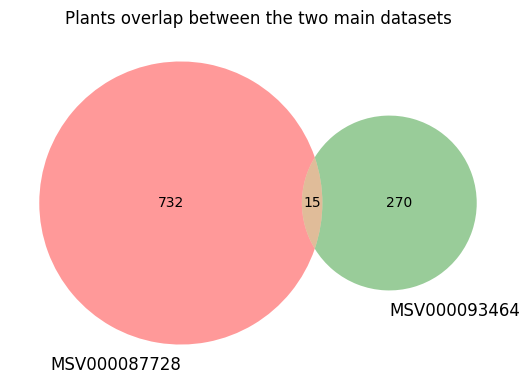

In [25]:
MSV000087728_plants = set(
    combined_df[combined_df["dataset"] == "MSV000087728"][
        "wikidata_species_id"
    ].unique()
)

MSV000093464_plants = set(
    combined_df[combined_df["dataset"] == "MSV000093464"][
        "wikidata_species_id"
    ].unique()
)

venn2(
    [MSV000087728_plants, MSV000093464_plants],
    set_labels=("MSV000087728", "MSV000093464"),
)

plt.title("Plants overlap between the two main datasets")

plt.show()

Let's look at the plants that overlap between the two main datasets

In [26]:
plants_in_both_dataset = MSV000087728_plants.intersection(MSV000093464_plants)

Let's look at the overlap of the precursor masses for the 15 plants present in both datasets

In [27]:
MSV000087728_subset = combined_df[
    combined_df["wikidata_species_id"].isin(plants_in_both_dataset)
    & (combined_df["dataset"] == "MSV000087728")
]

MSV000093464_subset = combined_df[
    combined_df["wikidata_species_id"].isin(plants_in_both_dataset)
    & (combined_df["dataset"] == "MSV000093464")
]

In [28]:
wikidata_mappings = pd.read_csv(
    f"{DATA_DIR}/processed/wikidata_ids_to_plant_names.csv",
)

# Get a dict mapping from ["ID", "mapped_curie"]
wikidata_to_name = wikidata_mappings.set_index("ID")["Species"].to_dict()
wikidata_mappings = wikidata_mappings.set_index("ID")["mapped_curie"].to_dict()

/Users/danieldomingo/Library/Caches/pypoetry/virtualenvs/unknown-chem-space-_ncANHMu-py3.10/lib/python3.10/site-packages/fsspec/registry.py:279: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


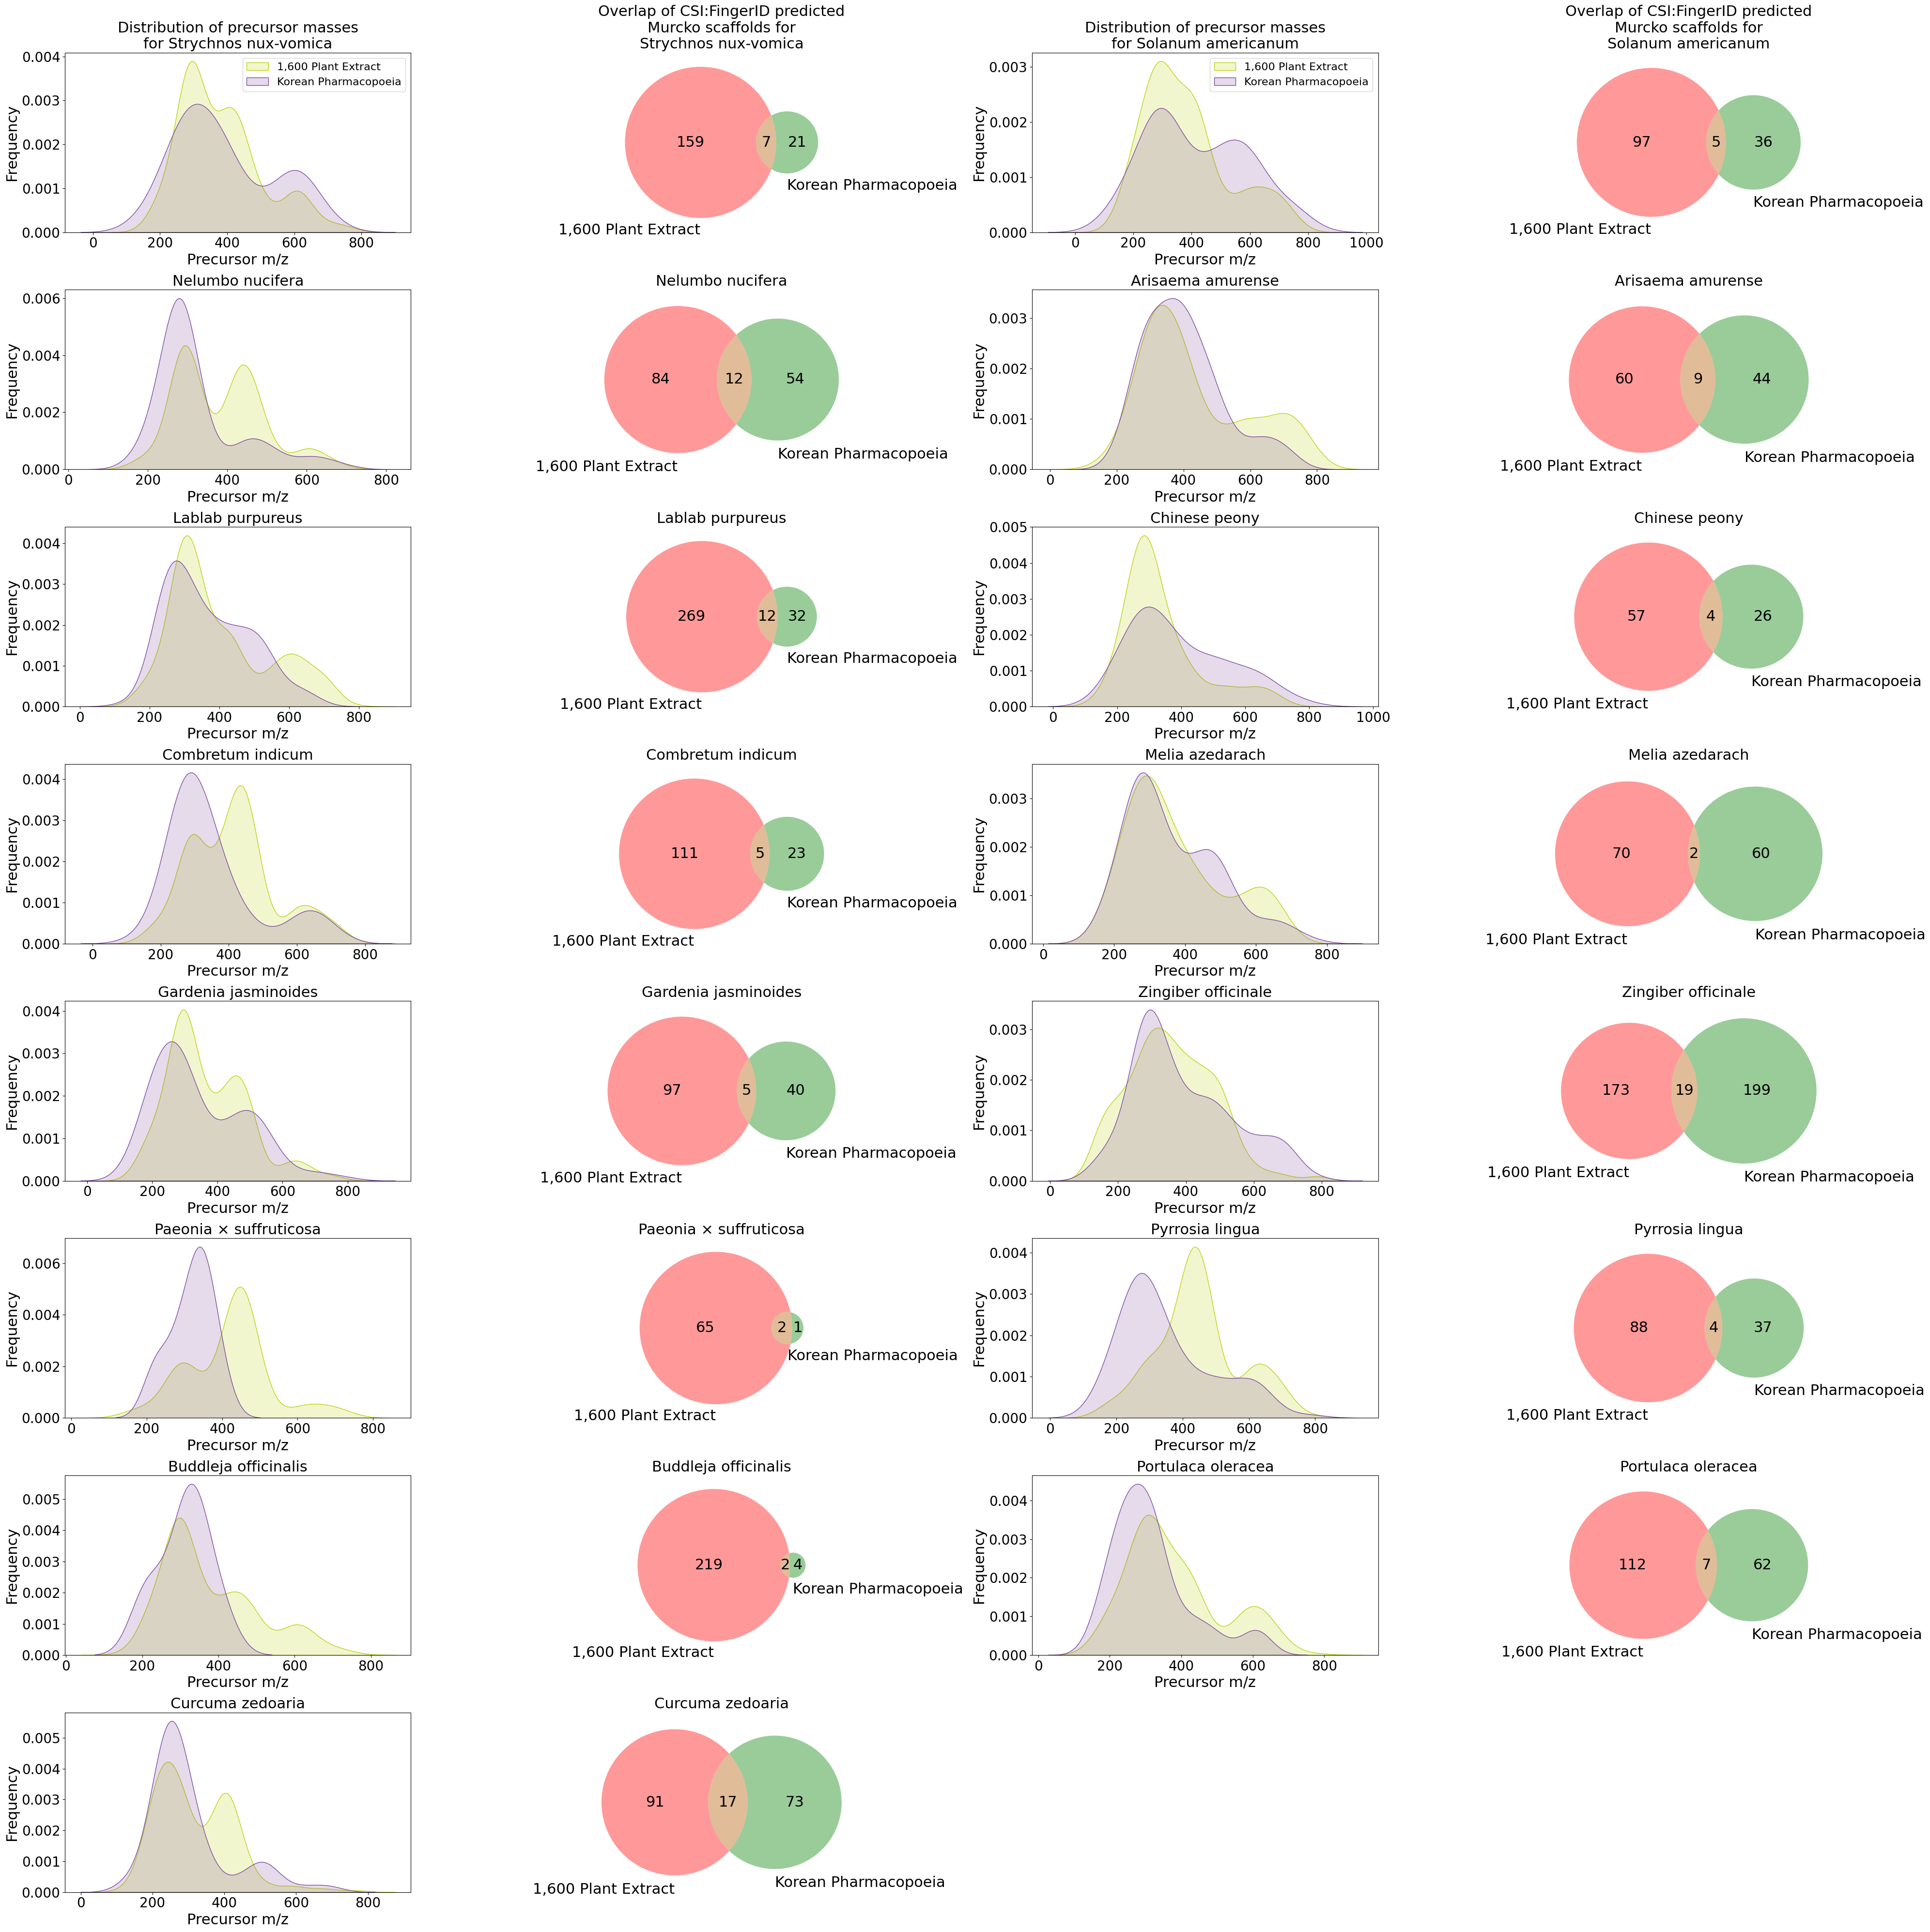

In [29]:
# Make a 8 x 4
fig, axs = plt.subplots(8, 4, figsize=(40, 40))

for i, species in enumerate(plants_in_both_dataset):
    pierre_fabre_plant = MSV000087728_subset[
        MSV000087728_subset["wikidata_species_id"] == species
    ]
    korean_med_plant = MSV000093464_subset[
        MSV000093464_subset["wikidata_species_id"] == species
    ]

    # if i is even then we are in the first two columns
    # if not then the third and forth
    if i % 2 == 0:
        ax_1 = axs[i // 2, 0]
        ax_2 = axs[i // 2, 1]
    else:
        ax_1 = axs[i // 2, 2]
        ax_2 = axs[i // 2, 3]

    # A) Plotting the distribution of the precursor masses
    # The first column is plotting the precursor m/z of each dataset with the same colors are above
    sns.kdeplot(
        pierre_fabre_plant["precursor_mz"],
        color="#BCD20B",
        label="1,600 Plant Extract",
        fill=True,
        alpha=0.2,
        ax=ax_1,
    )

    sns.kdeplot(
        korean_med_plant["precursor_mz"],
        color="#7D4B9E",
        label="Korean Pharmacopoeia",
        fill=True,
        alpha=0.2,
        ax=ax_1,
    )

    if i == 0 or i == 1:
        ax_1.legend(fontsize=16)

    # murcko scaffolds for each plant
    pierre_fabre_plant_murckos = set()
    for smiles in pierre_fabre_plant["smiles"]:
        try:
            pierre_fabre_plant_murckos.add(MurckoScaffoldSmiles(smiles))
        except:
            pass

    korean_med_plant_murckos = set()
    for smiles in korean_med_plant["smiles"]:
        try:
            korean_med_plant_murckos.add(MurckoScaffoldSmiles(smiles))
        except:
            pass

    venn = venn2(
        [
            pierre_fabre_plant_murckos,
            korean_med_plant_murckos,
        ],
        set_labels=("1,600 Plant Extract", "Korean Pharmacopoeia"),
        ax=ax_2,
    )

    if i == 0 or i == 1:
        ax_1.set_title(
            f"Distribution of precursor masses\nfor {wikidata_to_name[species]}",
            fontsize=22,
        )
    else:
        ax_1.set_title(
            f"{wikidata_to_name[species]}",
            fontsize=22,
        )

    if i == 0 or i == 1:
        ax_2.set_title(
            f"Overlap of CSI:FingerID predicted\nMurcko scaffolds for\n{wikidata_to_name[species]}",
            fontsize=22,
        )
    else:
        ax_2.set_title(
            f"{wikidata_to_name[species]}",
            fontsize=22,
        )

    for text in venn.subset_labels:
        text.set_fontsize(22)

    for text in venn.set_labels:
        text.set_fontsize(22)

    ax_1.set_xlabel("Precursor m/z", fontsize=22)
    ax_1.set_ylabel("Frequency", fontsize=22)

    # ticks with fontsize 20
    ax_1.tick_params(axis="x", labelsize=20)
    ax_1.tick_params(axis="y", labelsize=20)

# Remove the last two axes
ax_1 = axs[15 // 2, 2]
ax_2 = axs[15 // 2, 3]
ax_1.set_visible(False)
ax_2.set_visible(False)
ax_1.clear()
ax_2.clear()

plt.tight_layout()

plt.savefig(f"{FIGURE_DIR}/overlap_15_plants.png", dpi=450)

plt.show()

### Overview on the taxonomic distribution of the dataset

In [30]:
# Get all the taxonomy ids that start with "ncbitaxon"
ncbitaxon_ids = [
    curie for curie in wikidata_mappings.values() if curie.startswith("ncbitaxon")
]

print(
    f"{len(ncbitaxon_ids)}/{len(wikidata_mappings)} ({len(ncbitaxon_ids)/len(wikidata_mappings)*100:.2f}%)"
)

930/1018 (91.36%)


While not all of them are in NCBITaxonomy, the majority are so we are going to calculate the average taxonomic distance across all these 930 plants.

In [31]:
# Read the taxrank ontology
url = "http://purl.obolibrary.org/obo/ncbitaxon.obo"
print("loading graph (this might take a bit...)")
graph = obonet.read_obo(url)

# Get the childs of Viridiplantae (all plants)
plant_childs = networkx.ancestors(graph, "NCBITaxon:33090")
# Subset the graph to make it faster to the relevant part (plants only)
graph = graph.subgraph(plant_childs)

loading graph (this might take a bit...)


In [32]:
i = set()
for id_, data in graph.nodes(data=True):

    if "property_value" not in data:
        continue

    # Group edges based on the different taxonomic levels of interst
    for value in data["property_value"]:
        if value in ["has_rank NCBITaxon:genus"]:
            i.add(id_)

In [33]:
len(i)

17064

In [34]:
order_nodes = set()
family_nodes = set()
subfamily_nodes = set()
genus_nodes = set()

for id_, data in graph.nodes(data=True):

    if "property_value" not in data:
        continue

    # Group edges based on the different taxonomic levels of interst
    for value in data["property_value"]:
        if value == "has_rank NCBITaxon:order":
            order_nodes.add(id_)
        elif value == "has_rank NCBITaxon:family":
            family_nodes.add(id_)
        elif value == "has_rank NCBITaxon:subfamily":
            subfamily_nodes.add(id_)
        elif value == "has_rank NCBITaxon:genus":
            genus_nodes.add(id_)

species_to_order = defaultdict(list)
species_to_family = defaultdict(list)
species_to_subfamily = defaultdict(list)
species_to_genus = defaultdict(list)

# Build groups for each family and subfamilies
for node in tqdm(order_nodes, desc="order grouping"):
    children = set(networkx.ancestors(graph, node))
    for child in children:
        species_to_order[child].append(node)

# Build groups for each family and subfamilies
for node in tqdm(family_nodes, desc="family grouping"):
    children = set(networkx.ancestors(graph, node))
    for child in children:
        species_to_family[child].append(node)

for node in tqdm(subfamily_nodes, desc="subfamily_nodes grouping"):
    children = set(networkx.ancestors(graph, node))
    for child in children:
        species_to_subfamily[child].append(node)

for node in tqdm(genus_nodes, desc="genus_nodes grouping"):
    children = set(networkx.ancestors(graph, node))
    for child in children:
        species_to_genus[child].append(node)

print(len(species_to_order))
print(len(species_to_family))
print(len(species_to_subfamily))
print(len(species_to_genus))

genus_nodes grouping: 100%|██████████| 17064/17064 [28:26<00:00, 10.00it/s]

267717
265898
156213
245463


In [35]:
species_to_family["NCBITaxon:4075"]

['NCBITaxon:4070']

In [36]:
plant_df = combined_df[["wikidata_species_id"]].drop_duplicates()
plant_df["ncbitaxon_id"] = plant_df["wikidata_species_id"].map(wikidata_mappings)
plant_df["ncbitaxon_id"] = plant_df["ncbitaxon_id"].str.replace(
    "ncbitaxon:", "NCBITaxon:"
)
plant_df.dropna(inplace=True, subset=["ncbitaxon_id"])
plant_df.head()

,wikidata_species_id,ncbitaxon_id
0,Q715019,NCBITaxon:4075
86,Q162171,NCBITaxon:155640
147,Q5763748,NCBITaxon:265783
206,Q26932,NCBITaxon:4217
270,Q11086771,NCBITaxon:642532


In [37]:
plant_df["order"] = plant_df["ncbitaxon_id"].map(species_to_order)
plant_df["family"] = plant_df["ncbitaxon_id"].map(species_to_family)
plant_df["subfamily"] = plant_df["ncbitaxon_id"].map(species_to_subfamily)
plant_df["genus"] = plant_df["ncbitaxon_id"].map(species_to_genus)

In [38]:
plant_df.head()

,wikidata_species_id,ncbitaxon_id,order,family,subfamily,genus
0,Q715019,NCBITaxon:4075,[NCBITaxon:4069],[NCBITaxon:4070],[NCBITaxon:424551],[NCBITaxon:4074]
86,Q162171,NCBITaxon:155640,[NCBITaxon:41937],[NCBITaxon:43707],[],[NCBITaxon:43708]
147,Q5763748,NCBITaxon:265783,[NCBITaxon:4209],[NCBITaxon:4210],[NCBITaxon:102804],[NCBITaxon:4219]
206,Q26932,NCBITaxon:4217,[NCBITaxon:4209],[NCBITaxon:4210],[NCBITaxon:219103],[NCBITaxon:4216]
270,Q11086771,NCBITaxon:642532,[NCBITaxon:41945],[NCBITaxon:4345],[NCBITaxon:217032],[NCBITaxon:13650]


In [39]:
def get_taxon_tree_by_level(df, level):
    tree = defaultdict(set)

    for idx, row in df.iterrows():
        for taxon in row[level]:
            tree[taxon].add(row["wikidata_species_id"])
    return tree


orders = get_taxon_tree_by_level(plant_df, "order")
families = get_taxon_tree_by_level(plant_df, "family")
subfamilies = get_taxon_tree_by_level(plant_df, "subfamily")
genera = get_taxon_tree_by_level(plant_df, "genus")

print(
    f"""
    Orders: {len(orders)}
    Families: {len(families)}
    Subfamilies: {len(subfamilies)}
    Genera: {len(genera)}
"""
)


    Orders: 61
    Families: 181
    Subfamilies: 113
    Genera: 672



In [40]:
node2name = {
    id_: data["name"] for id_, data in graph.nodes(data=True) if "name" in data
}

In [41]:
order_tree_df = pd.DataFrame(columns=["order"])
order_tree_df["order"] = list(orders.keys())
order_tree_df["order_name"] = order_tree_df["order"].map(node2name)
order_tree_df["species_count"] = order_tree_df["order"].map(lambda x: len(orders[x]))
order_tree_df["plant_percentage"] = (
    order_tree_df["species_count"] / plant_df["wikidata_species_id"].nunique()
) * 100
order_tree_df.sort_values("species_count", ascending=False).head(10)

,order,order_name,species_count,plant_percentage
24,NCBITaxon:72025,Fabales,79,7.760314
12,NCBITaxon:3646,Malpighiales,71,6.974460
14,NCBITaxon:4055,Gentianales,69,6.777996
1,NCBITaxon:41937,Sapindales,65,6.385069
5,NCBITaxon:4143,Lamiales,60,5.893910
2,NCBITaxon:4209,Asterales,58,5.697446
19,NCBITaxon:3744,Rosales,50,4.911591
10,NCBITaxon:41938,Malvales,43,4.223969
6,NCBITaxon:3524,Caryophyllales,32,3.143418
4,NCBITaxon:73496,Asparagales,31,3.045187


In [42]:
fam_tree_df = pd.DataFrame(columns=["family"])
fam_tree_df["family"] = list(families.keys())
fam_tree_df["family_name"] = fam_tree_df["family"].map(node2name)
fam_tree_df["species_count"] = fam_tree_df["family"].map(lambda x: len(families[x]))
fam_tree_df["plant_percentage"] = (
    fam_tree_df["species_count"] / plant_df["wikidata_species_id"].nunique()
) * 100
fam_tree_df.sort_values("species_count", ascending=False).head(5)

,family,family_name,species_count,plant_percentage
49,NCBITaxon:3803,Fabaceae,77,7.563851
2,NCBITaxon:4210,Asteraceae,50,4.911591
12,NCBITaxon:3629,Malvaceae,35,3.438114
31,NCBITaxon:4056,Apocynaceae,30,2.946955
41,NCBITaxon:4136,Lamiaceae,29,2.848723


In [43]:
subfam_tree_df = pd.DataFrame(columns=["subfamily"])
subfam_tree_df["subfamily"] = list(subfamilies.keys())
subfam_tree_df["subfamily_name"] = subfam_tree_df["subfamily"].map(node2name)
subfam_tree_df["species_count"] = subfam_tree_df["subfamily"].map(
    lambda x: len(subfamilies[x])
)
subfam_tree_df["plant_percentage"] = (
    subfam_tree_df["species_count"] / plant_df["wikidata_species_id"].nunique()
) * 100
subfam_tree_df.sort_values("species_count", ascending=False).head(5)

,subfamily,subfamily_name,species_count,plant_percentage
20,NCBITaxon:3814,Papilionoideae,48,4.715128
1,NCBITaxon:102804,Asteroideae,33,3.241650
26,NCBITaxon:3804,Caesalpinioideae,23,2.259332
17,NCBITaxon:216706,Nepetoideae,15,1.473477
61,NCBITaxon:167487,Rauvolfioideae,15,1.473477


In [44]:
genus_tree_df = pd.DataFrame(columns=["genus"])
genus_tree_df["genus"] = list(genera.keys())
genus_tree_df["genus_name"] = genus_tree_df["genus"].map(node2name)
genus_tree_df["species_count"] = genus_tree_df["genus"].map(lambda x: len(genera[x]))
genus_tree_df["plant_percentage"] = (
    genus_tree_df["species_count"] / plant_df["wikidata_species_id"].nunique()
) * 100
genus_tree_df.sort_values("species_count", ascending=False).head(5)

,genus,genus_name,species_count,plant_percentage
257,NCBITaxon:58227,Garcinia,9,0.884086
62,NCBITaxon:2706,Citrus,7,0.687623
2,NCBITaxon:4219,Artemisia,6,0.589391
16,NCBITaxon:3990,Euphorbia,6,0.589391
34,NCBITaxon:4107,Solanum,6,0.589391
